In [1]:
# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
from astropy.coordinates import search_around_sky   # functional interface

# Local
import util
import utils


In [ ]:
size_ratio = 1
sub_width, sub_height = size_ratio*10/3, size_ratio*2.8
SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 11

rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = SMALL_SIZE
rc_default['axes.labelsize'] = MEDIUM_SIZE
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = MEDIUM_SIZE
rc_default['xtick.labelsize'] = SMALL_SIZE
rc_default['ytick.labelsize'] = SMALL_SIZE
rc_default['legend.fontsize'] = SMALL_SIZE
rc_default['figure.titlesize'] = BIGGER_SIZE
rc_default['lines.linewidth'] = 1
rc_default['lines.markersize'] = 4
rc_default['figure.figsize'] = (sub_width, sub_height)
rc_default['savefig.dpi'] = 300

# Latex related
rc_default['text.usetex'] = True
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)
plt.style.use('tableau-colorblind10')

In [3]:
def mask_radius_for_mag(mag):
    """
    returns a masking radius in degrees for a star of the given magnitude.
    Used for Tycho-2 and Gaia stars.
    This is in degrees, and is from Rongpu in the thread [decam-chatter 12099].

    Parameters
    ----------
    mag : float
        The magnitude of the star.
    Returns
    -------
    float
        The masking radius in degrees.
    """
    return 1630./3600. * 1.396**(-mag)

def mask_radius_DR9(g_mag):
    """
    Legacy Surveys DR9 bright-star mask radius (arcsec) vs Gaia G.
    Parameters
    ----------
    g_mag : float
        The Gaia G magnitude of the star.
    Returns
    -------
    float
        The masking radius in degrees.
    """

    return(0.5 * mask_radius_for_mag(g_mag))



In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [5]:
Legacy_path = "/home/ir-band1/1-research/1-4MOST/3-CRS/2-data/1-BG/desi_bg_nomaskbit_mask_4M_reduced_columns.fits"

In [6]:
Gaia_path = "/home/ir-band1/1-research/1-4MOST/3-CRS/2-data/8-Legacy_masks/gaia-mask-dr10.fits.gz"

In [7]:
BG = Table.read(Legacy_path)

In [8]:
gaia = Table.read(Gaia_path)

In [9]:
BG

OBJID,RA,DEC,EBV,WISEMASK_W1,MASKBITS,isBG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_g,mag_i,mag_w1,isBG_4M_v2,desi_bgs_selection,galactic_cap,dr1_bg_mask
,deg,deg,,,,,,,,,,,,,,,
int32,float64,float64,float32,uint8,int32,bool,bool,bool,float32,float32,float32,float32,float32,bool,bool,bytes3,bool
419,157.0072201498557,-2.1468467554514508,0.044455066,0,0,False,False,True,19.254793,18.32375,20.694925,18.70724,17.812822,False,False,NGC,True
645,157.01433423838904,-2.2641702674806825,0.041389566,0,0,False,False,True,18.899773,18.50198,19.443045,18.654955,18.839195,False,True,NGC,True
838,157.0200785116195,-2.3639337222354797,0.039800275,0,0,False,False,True,18.914272,18.500732,19.573341,18.65716,19.303652,False,True,NGC,True
1164,157.02686834051426,-2.159646811120505,0.043790996,0,0,True,False,True,18.984041,18.54076,19.72362,18.707792,18.666428,False,True,NGC,True
1219,157.0281576193182,-2.272059179114334,0.041178815,0,0,True,False,True,18.530964,17.854332,19.707085,18.141018,17.93635,True,True,NGC,True
1576,157.03549970264152,-2.270895163249637,0.041185517,0,0,True,False,True,18.15484,17.266401,19.582981,17.617146,16.646183,True,True,NGC,True
1690,157.03851793006055,-2.226166286097986,0.042040892,0,0,False,False,True,19.321472,18.318218,21.130793,18.684061,17.62561,False,False,NGC,True
1940,157.04382620147746,-2.1518624340791046,0.04378916,0,0,False,False,True,19.178022,18.516327,20.12455,18.78125,18.564873,False,True,NGC,True


In [10]:
gaia.columns

<TableColumns names=('ra','dec','ref_cat','ref_id','ref_epoch','mag','mask_mag','radius','radius_pix','pmra','pmdec','parallax','ra_ivar','dec_ivar','pmra_ivar','pmdec_ivar','parallax_ivar','in_desi','istycho','isgaia','isbright','ismedium','pointsource','donotfit','decam_mag_g','decam_mag_r','decam_mag_i','decam_mag_z','zguess','brickname','ibx','iby','gaia_phot_g_mean_mag','gaia_phot_g_mean_flux_over_error','gaia_phot_g_n_obs','gaia_phot_bp_mean_mag','gaia_phot_bp_mean_flux_over_error','gaia_phot_rp_mean_mag','gaia_phot_rp_mean_flux_over_error','gaia_astrometric_excess_noise','gaia_astrometric_excess_noise_sig','gaia_duplicated_source','gaia_phot_bp_rp_excess_factor','gaia_astrometric_sigma5d_max','gaia_astrometric_params_solved','gaia_ipd_frac_multi_peak','gaia_ipd_gof_harmonic_amplitude','gaia_ruwe')>

In [11]:
gaia

ra,dec,ref_cat,ref_id,ref_epoch,mag,mask_mag,radius,radius_pix,pmra,pmdec,parallax,ra_ivar,dec_ivar,pmra_ivar,pmdec_ivar,parallax_ivar,in_desi,istycho,isgaia,isbright,ismedium,pointsource,donotfit,decam_mag_g,decam_mag_r,decam_mag_i,decam_mag_z,zguess,brickname,ibx,iby,gaia_phot_g_mean_mag,gaia_phot_g_mean_flux_over_error,gaia_phot_g_n_obs,gaia_phot_bp_mean_mag,gaia_phot_bp_mean_flux_over_error,gaia_phot_rp_mean_mag,gaia_phot_rp_mean_flux_over_error,gaia_astrometric_excess_noise,gaia_astrometric_excess_noise_sig,gaia_duplicated_source,gaia_phot_bp_rp_excess_factor,gaia_astrometric_sigma5d_max,gaia_astrometric_params_solved,gaia_ipd_frac_multi_peak,gaia_ipd_gof_harmonic_amplitude,gaia_ruwe
deg,deg,,,,,,deg,,mas / yr,mas / yr,mas,1/deg^2,1/deg^2,1/(mas/yr)^2,1/(mas/yr)^2,1/mas^2,,,,,,,,,,,,,,,,mag,,,mag,,mag,,,,,,,,,,
float64,float64,bytes2,int64,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,bytes8,int32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,bool,float32,float32,uint8,float64,float32,float32
253.76501905977184,36.39714066211841,GE,1351126312514200192,2016.0,10.510451,10.510451,0.0135854455,187,2.3583913,-52.31047,2.9681907,1.5388287e+17,1.3171264e+17,7338.426,6056.5273,7891.1313,True,True,True,True,True,True,False,10.779598,10.448892,10.377066,10.376121,10.376121,2537p365,1157,386,10.510451,6990.217,430,10.784817,1922.0018,10.074063,3379.6045,0.10013094,16.31202,False,1.1924475,0.018223906,31,0.0,0.006638479,1.0711644
253.5576114492707,36.56872894182513,GE,1351143973419728128,2016.0,11.878395,11.878395,0.008607534,119,-14.177853,3.2581644,4.2547874,5.4014084e+16,4.538665e+16,2341.3213,2106.9263,2775.943,True,False,True,True,True,True,False,12.259853,11.783483,11.653846,11.616769,11.616769,2537p365,3447,2745,11.878395,4472.722,412,12.230982,1564.8464,11.347253,2548.626,0.20301989,68.72492,False,1.2106694,0.032004472,31,3.0,0.0064465515,1.7021251
253.64894172373394,36.39397513418334,GE,1351125930260611584,2016.0,12.017935,12.017935,0.00821602,113,2.984219,-15.970342,2.4469101,1187753500000000.0,847080700000000.0,54.5408,37.924076,60.54345,True,False,True,True,True,True,False,12.395912,11.923948,11.795903,11.759927,11.759927,2537p365,2441,343,12.017935,3450.7659,429,12.369602,1863.9563,11.490862,3511.6375,1.509902,3546.498,False,1.2085452,0.23155612,31,0.0,0.02463731,13.335421
253.6081935493283,36.44299396510061,GE,1351129233092011264,2016.0,12.547916,12.547916,0.006884539,95,0.81866807,-27.24657,1.4396032,2.1487507e+17,1.3536374e+17,9807.75,6505.4463,10363.84,True,False,True,True,True,True,False,12.941789,12.449767,12.31452,12.273541,12.273541,2537p365,2891,1017,12.547916,5053.6577,476,12.9164095,1813.9033,12.015088,4264.064,0.070731804,7.1850424,False,1.2041136,0.01773249,31,0.0,0.005440279,1.0461098
253.6189270238864,36.37878609826635,GE,1351125861541135744,2016.0,12.768269,12.768269,0.0063965977,88,-4.675216,-24.053497,2.5197196,1.8285767e+17,1.1350168e+17,8454.221,5968.0273,8983.3,True,False,True,True,True,True,False,13.106384,12.685375,12.576407,12.553177,12.553177,2537p365,2773,134,12.768269,4981.493,417,13.09648,1272.6603,12.276626,2996.7896,0.06428269,5.1587405,False,1.1980417,0.019128736,31,0.0,0.026165813,0.99508303
253.6061669636778,36.617023604073665,GE,1351144626254757376,2016.0,12.919198,12.919198,0.0060824924,84,-2.8868985,-0.107091494,0.3388763,1.5300854e+17,1.2210525e+17,7004.5903,5766.134,7809.665,True,False,True,True,True,True,False,13.643943,12.766895,12.5000725,12.368286,12.368286,2537p365,2910,3408,12.919198,5697.668,416,13.489741,1782.1172,12.204825,2749.0881,0.080570415,8.082757,False,1.2415544,0.019211493,31,0.0,0.010912211,1.009843
253.6432265636972,36.5463119641311,GE,1351132188029464960,2016.0,12.928805,12.928805,0.0060630287,84,-0.26408,-7.023377,0.87807244,1.4437964e+17,9.291823e+16,6509.0776,4437.9297,7279.115,True,False,True,True,Tru

In [12]:
gaia.keep_columns(['ra', 'dec', 'mask_mag', 'radius', 'isbright', 'ismedium'])

In [13]:
gaia.rename_column('ra', 'RA')
gaia.rename_column('dec', 'DEC')
gaia.rename_column('mask_mag', 'G')

In [14]:
gaia.write(Gaia_path.replace('.fits.gz', '_reduced_columns.fits'), overwrite=True)

In [15]:
BG = BG[(BG['isBG_4M_v2'] == True)]
# BG.keep_columns(['RA', 'DEC', 'in_S8', 'MASKBITS', 'isBG_4M_v2'])


In [16]:
BG = BG.to_pandas()


In [17]:
gaia = gaia.to_pandas()

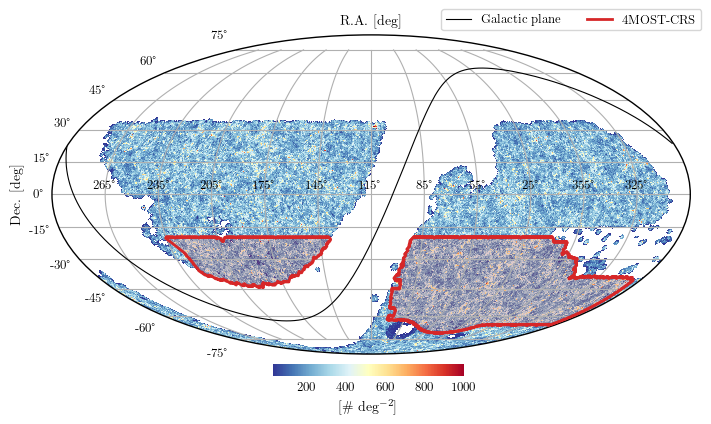

In [18]:
hpmap = utils.create_hp_map(BG['RA'], BG['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

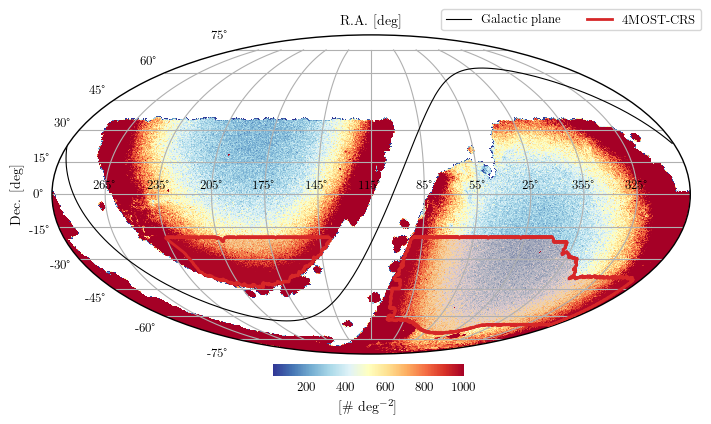

In [19]:
hpmap = utils.create_hp_map(gaia['RA'], gaia['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

In [20]:
print(max(gaia['G']), min(gaia['G']))

99.0 -0.669127345085144


In [114]:
mag_bins = [(7, 11), (11, 12), (12, 13), (13, 16)]

In [22]:
# ------------------ one-off SkyCoord creation for BG ------------------
cats = SkyCoord(ra=BG['RA'].values * u.deg,
                dec=BG['DEC'].values * u.deg)

In [23]:
mag_bin = (7, 11)  # example bin

In [24]:
sel      = (gaia['G'] > mag_bin[0]) & (gaia['G'] <= mag_bin[1])
bright   = gaia.loc[sel].reset_index(drop=True)          # contiguous 0…N−1
stars    = SkyCoord(bright['RA'].values * u.deg,
                    bright['DEC'].values * u.deg)

In [25]:
R_DR9 = mask_radius_DR9(bright['G'].values)       # degrees
R_outer = 4.0 * R_DR9.max()                    # degrees
print(f"R_max = {R_outer:.2f} degrees")

R_max = 0.09 degrees


In [26]:
sidx, gidx, sep2d, _ = search_around_sky(stars, cats, R_outer * u.deg)


In [27]:
sidx

array([   180,    183,    183, ..., 484070, 484070, 484070],
      shape=(2317706,))

In [28]:
gidx

array([4641804, 4641736, 4641737, ..., 2478080, 2478246, 2478249],
      shape=(2317706,))

In [29]:
# 4.  Clip to < 4 × the *individual* star’s mask radius
keep          = sep2d.value <= (4.0 * R_DR9.max())
# sidx, gidx    = sidx[keep], gidx[keep]

In [30]:
ra_bg, dec_bg = cats[gidx].ra.deg, cats[gidx].dec.deg
ra_st, dec_st = stars[sidx].ra.deg, stars[sidx].dec.deg

In [31]:
dRAc = (ra_bg - ra_st) * np.cos(dec_st)
dDec = dec_bg - dec_st

In [32]:
# compute DR9 mask‐radii and scale
mags_at_idx = bright['G'].values[sidx]
R9_arcsec   = mask_radius_DR9(mags_at_idx) * 3600.0  # convert to arcsec
x = dRAc * 3600.0 / R9_arcsec
y = dDec * 3600.0 / R9_arcsec

In [97]:
nbins = 200

In [98]:
H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-5,5],[-5,5]])


In [99]:
Xc, Yc = (xe[:-1]+xe[1:]), (ye[:-1]+ye[1:])
XX, YY = np.meshgrid(Xc,Yc)
R = np.sqrt(XX**2 + YY**2)
mask = (R>1.1) & (R<4)
eta_mean = H[mask].mean()
density_ratio = H / eta_mean

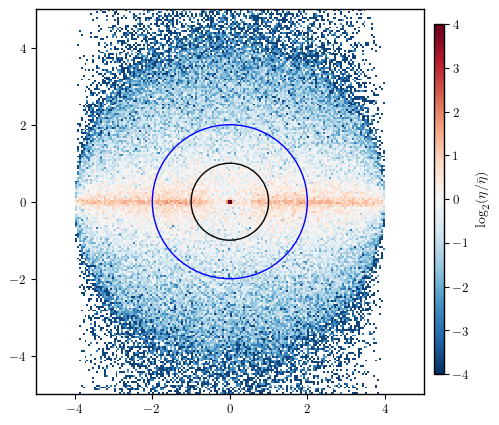

In [100]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(5, 5))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# 9. Plot
# fig, ax = plt.subplots(figsize=(6,6))
pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio), cmap='RdBu_r', vmin=-4, vmax=4)

    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
for rad, col in [(1,'k'), (2,'b')]:
    circ = Circle((0,0), radius=rad, fill=False, ls='-', lw=1, ec=col)
    ax.add_patch(circ)
# ax.text (0.95, 0.95, fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
#     transform=ax.transAxes, fontsize=20, verticalalignment='top',
#     horizontalalignment='right', bbox=dict(facecolor='white', alpha=1, edgecolor='gray', boxstyle='round,pad=0.1'))
    
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
# ax.axhline(0, color='k', lw=0.5, ls='--')
# ax.axvline(0, color='k', lw=0.5, ls='--')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')


In [85]:
hist_range = 4
deltar_size = 0.05
bin_number = int(2*hist_range/deltar_size)

In [86]:
bin_number

160

In [121]:
overdensity_dict = {}

R_max = 0.11 degrees
R_max = 0.03 degrees
R_max = 0.02 degrees
R_max = 0.01 degrees


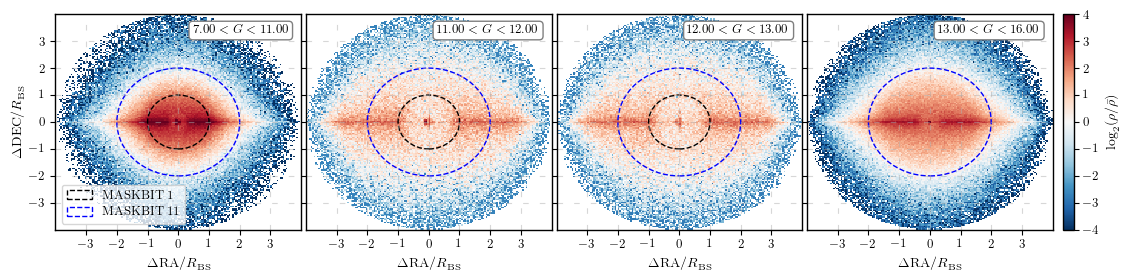

In [122]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten() if nrows * ncols > 1 else [axes]
for i, mag_bin in enumerate(mag_bins):
    ax = axes[i]
    sel      = (gaia['G'] > mag_bin[0]) & (gaia['G'] <= mag_bin[1])
    bright   = gaia.loc[sel].reset_index(drop=True)          # contiguous 0…N−1
    stars    = SkyCoord(bright['RA'].values * u.deg,
                        bright['DEC'].values * u.deg)

    R_DR9 = mask_radius_DR9(bright['G'].values)       # degrees
    R_outer = 5.0 * R_DR9.max()                    # degrees
    print(f"R_max = {R_outer:.2f} degrees")

    sidx, gidx, sep2d, _ = search_around_sky(stars, cats, R_outer * u.deg)

    # 4.  Clip to < 4 × the *individual* star’s mask radius
    keep          = sep2d.value <= (4.0 * R_DR9[sidx])
    sidx, gidx    = sidx[keep], gidx[keep]

    ra_bg, dec_bg = cats[gidx].ra.deg, cats[gidx].dec.deg
    ra_st, dec_st = stars[sidx].ra.deg, stars[sidx].dec.deg

    dRAc = (ra_bg - ra_st) * np.cos(dec_st)
    dDec = dec_bg - dec_st

    # ra_bg_plot, dec_bg_plot = cats[gidx_plot].ra.deg, cats[gidx_plot].dec.deg
    # ra_st_plot, dec_st_plot = stars[sidx_plot].ra.deg, stars[sidx_plot].dec.deg

    # dRAc_plot = (ra_bg_plot - ra_st_plot) * np.cos(dec_st_plot)
    # dDec_plot = dec_bg_plot - dec_st_plot

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[sidx]
    R9_arcsec   = max(mask_radius_DR9(mags_at_idx)) * 3600.0  # convert to arcsec
    x = dRAc * 3600.0 / R9_arcsec
    y = dDec * 3600.0 / R9_arcsec

    H, xe, ye = np.histogram2d(x, y, bins=bin_number, range=[[-hist_range,hist_range],[-hist_range,hist_range]])

    Xc, Yc = (xe[:-1]+xe[1:]), (ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)

    mask = (R>1.1) & (R<8)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean
    density_ratio[R>8] = np.nan  # mask out values outside the circle
    mask_radius_lable = ['MASKBIT 1', 'MASKBIT 11']

    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio), cmap='RdBu_r', vmin=-4, vmax=4)

    overdensity_dict[i] = {
        'pcm': pcm,
        'mag_bin': mag_bin,
        'R_outer': R_outer,
        'xe': xe,
        'ye': ye,
        'density_ratio': density_ratio,
    }

        # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    if mag_bin[1]<=13:
        for rad, col in [(1,'k'), (2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    else:
        for rad, col in [(2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col,label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    
    # for rad, col in [(1,'k'), (2,'b')]:
        # circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        # ax.add_patch(circ)
    
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
plt.savefig('gaia_mask_BG_4x1.png', dpi=400, bbox_inches='tight')
plt.savefig('gaia_mask_BG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()

In [125]:
import pickle

with open('overdensity_dict_bg.pkl', 'wb') as f:
    pickle.dump(overdensity_dict, f)

R_max = 0.11 degrees
R_max = 0.03 degrees
R_max = 0.02 degrees
R_max = 0.01 degrees
R_max = 0.01 degrees
R_max = 0.01 degrees


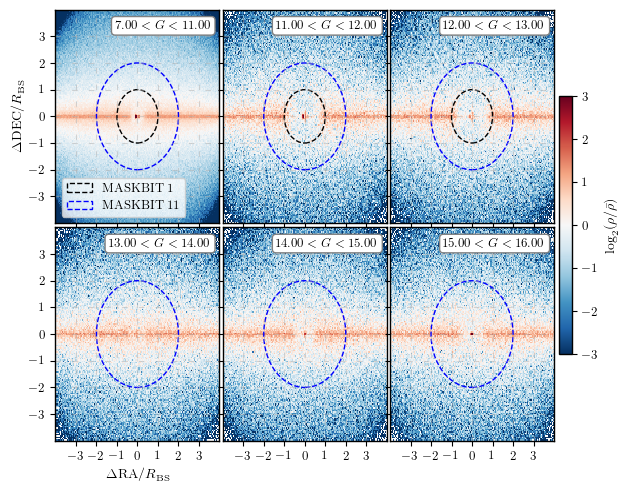

In [89]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*2, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten() if nrows * ncols > 1 else [axes]
for i, mag_bin in enumerate(mag_bins):
    ax = axes[i]
    sel      = (gaia['G'] > mag_bin[0]) & (gaia['G'] <= mag_bin[1])
    bright   = gaia.loc[sel].reset_index(drop=True)          # contiguous 0…N−1
    stars    = SkyCoord(bright['RA'].values * u.deg,
                        bright['DEC'].values * u.deg)

    R_DR9 = mask_radius_DR9(bright['G'].values)       # degrees
    R_outer = 5.0 * R_DR9.max()                    # degrees
    print(f"R_max = {R_outer:.2f} degrees")

    sidx, gidx, sep2d, _ = search_around_sky(stars, cats, R_outer * u.deg)

    # 4.  Clip to < 4 × the *individual* star’s mask radius
    keep          = sep2d.value <= (4.0 * R_DR9[sidx])
    # sidx, gidx    = sidx[keep], gidx[keep]

    ra_bg, dec_bg = cats[gidx].ra.deg, cats[gidx].dec.deg
    ra_st, dec_st = stars[sidx].ra.deg, stars[sidx].dec.deg

    dRAc = (ra_bg - ra_st) * np.cos(dec_st)
    dDec = dec_bg - dec_st

    # ra_bg_plot, dec_bg_plot = cats[gidx_plot].ra.deg, cats[gidx_plot].dec.deg
    # ra_st_plot, dec_st_plot = stars[sidx_plot].ra.deg, stars[sidx_plot].dec.deg

    # dRAc_plot = (ra_bg_plot - ra_st_plot) * np.cos(dec_st_plot)
    # dDec_plot = dec_bg_plot - dec_st_plot

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[sidx]
    R9_arcsec   = max(mask_radius_DR9(mags_at_idx)) * 3600.0  # convert to arcsec
    x = dRAc * 3600.0 / R9_arcsec
    y = dDec * 3600.0 / R9_arcsec

    H, xe, ye = np.histogram2d(x, y, bins=bin_number, range=[[-hist_range,hist_range],[-hist_range,hist_range]])

    Xc, Yc = (xe[:-1]+xe[1:]), (ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)

    mask = (R>2) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean
    # density_ratio[R>8] = np.nan  # mask out values outside the circle
    mask_radius_lable = ['MASKBIT 1', 'MASKBIT 11']

    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio), cmap='RdBu_r', vmin=-3, vmax=3)

        # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    if mag_bin[1]<=13:
        for rad, col in [(1,'k'), (2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    else:
        for rad, col in [(2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col,label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    
    # for rad, col in [(1,'k'), (2,'b')]:
        # circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        # ax.add_patch(circ)
    
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
# plt.savefig('gaia_mask_BG_4x1.png', dpi=400, bbox_inches='tight')
# plt.savefig('gaia_mask_BG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()

R_max = 0.09 degrees


R_max = 0.02 degrees
R_max = 0.02 degrees
R_max = 0.01 degrees
R_max = 0.01 degrees
R_max = 0.01 degrees


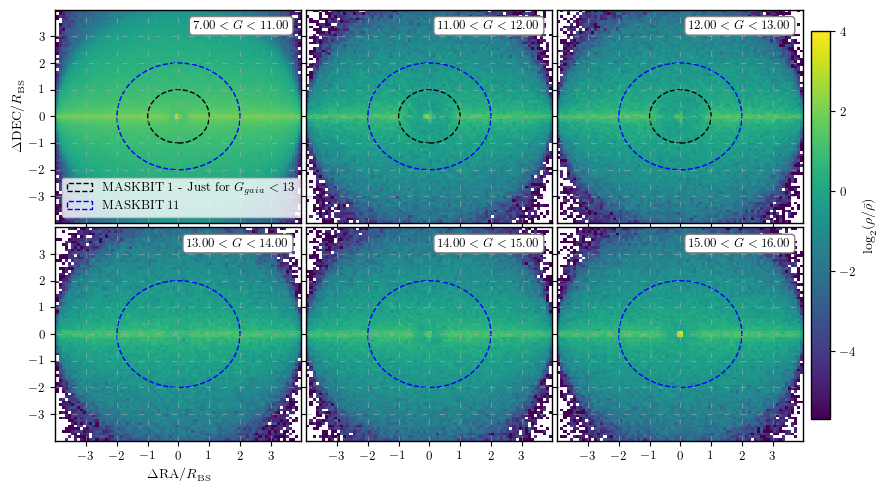

In [96]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten() if nrows * ncols > 1 else [axes]
for i, mag_bin in enumerate(mag_bins):
    ax = axes[i]
    sel      = (gaia['G'] > mag_bin[0]) & (gaia['G'] <= mag_bin[1])
    bright   = gaia.loc[sel].reset_index(drop=True)          # contiguous 0…N−1
    stars    = SkyCoord(bright['RA'].values * u.deg,
                        bright['DEC'].values * u.deg)

    R_DR9 = mask_radius_DR9(bright['G'].values)       # degrees
    R_outer = 4.0 * R_DR9.max()                    # degrees
    print(f"R_max = {R_outer:.2f} degrees")

    sidx, gidx, sep2d, _ = search_around_sky(stars, cats, R_outer * u.deg)

    # 4.  Clip to < 4 × the *individual* star’s mask radius
    keep          = sep2d.value <= (4.0 * R_DR9[sidx])
    sidx_plot, gidx_plot    = sidx[keep], gidx[keep]

    ra_bg, dec_bg = cats[gidx].ra.deg, cats[gidx].dec.deg
    ra_st, dec_st = stars[sidx].ra.deg, stars[sidx].dec.deg

    dRAc = (ra_bg - ra_st) * np.cos(dec_st)
    dDec = dec_bg - dec_st

    ra_bg_plot, dec_bg_plot = cats[gidx_plot].ra.deg, cats[gidx_plot].dec.deg
    ra_st_plot, dec_st_plot = stars[sidx_plot].ra.deg, stars[sidx_plot].dec.deg

    dRAc_plot = (ra_bg_plot - ra_st_plot) * np.cos(dec_st_plot)
    dDec_plot = dec_bg_plot - dec_st_plot

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[sidx]
    R9_arcsec   = max(mask_radius_DR9(mags_at_idx)) * 3600.0  # convert to arcsec
    x = dRAc * 3600.0 / R9_arcsec
    y = dDec * 3600.0 / R9_arcsec

    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-10,10],[-10,10]])

    Xc, Yc = (xe[:-1]+xe[1:]), (ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)

    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']

    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio),
                            vmax=4)

        # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    if mag_bin[1]<=13:
        for rad, col in [(1,'k'), (2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    else:
        for rad, col in [(2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col,label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    
    # for rad, col in [(1,'k'), (2,'b')]:
        # circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        # ax.add_patch(circ)
    
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
# plt.savefig('gaia_mask_BG_4x1.png', dpi=400, bbox_inches='tight')
# plt.savefig('gaia_mask_BG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()